In [1]:
# Load processed data
import numpy as np
import pandas as pd 

df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')
X_train = np.load('X_train.npy', allow_pickle=True)
X_test = np.load('X_test.npy', allow_pickle=True)

# Define scoring function

In [2]:
from sklearn.metrics import mean_tweedie_deviance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from functools import partial
import matplotlib.pyplot as plt

def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics

    Parameters
    ----------
    estimator : model object
        fitted model to the frequency data example: (poisson_freq, gamma_sev), tweedie, XGB
    X_train: array
        enocoded independent variables for train data
    X_test: array
        enocoded independent variables for test data
    df_train: DataFrame
        a dataframe, with the same index as X_train, with the target variables
    df_test: DataFrame
        a dataframe, with the same index as X_test, with the target variables
    target : str
        column name of df_train/df_test with the values of observed target
    weight : str
        column name of df with the values of weights or exposure
    tweedie_powers : list of floats, default=None
        list of values for tweedie model power parameter
    """

    metrics = [
        ("D² explained", None),  # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [("train", X_train, df_train), ("test", X_test, df_test)]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res



def plot_obs_pred(
    df,
    feature,
    weight,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )

# Fit and evaluate models

In [3]:
## Fit Poisson model to Frequency
# The parameters of the model are estimated by minimizing the Poisson deviance
# on the training set via a quasi-Newton solver: l-BFGS. Some of the features
# are collinear, we use a weak penalization (alpha=1e-3) to avoid numerical issues.

from sklearn.linear_model import PoissonRegressor

poisson_freq = PoissonRegressor(alpha=1e-3, max_iter=400)
poisson_freq.fit(X_train, df_train["Frequency"], sample_weight=df_train["Exposure"])

scores_poisson = score_estimator(
    poisson_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
display(scores_poisson)

Evaluation of PoissonRegressor on target Frequency


subset,train,test
metric,,
D² explained,0.0198,0.0223
mean abs. error,0.1380,0.1377
mean squared error,0.2440,0.2237


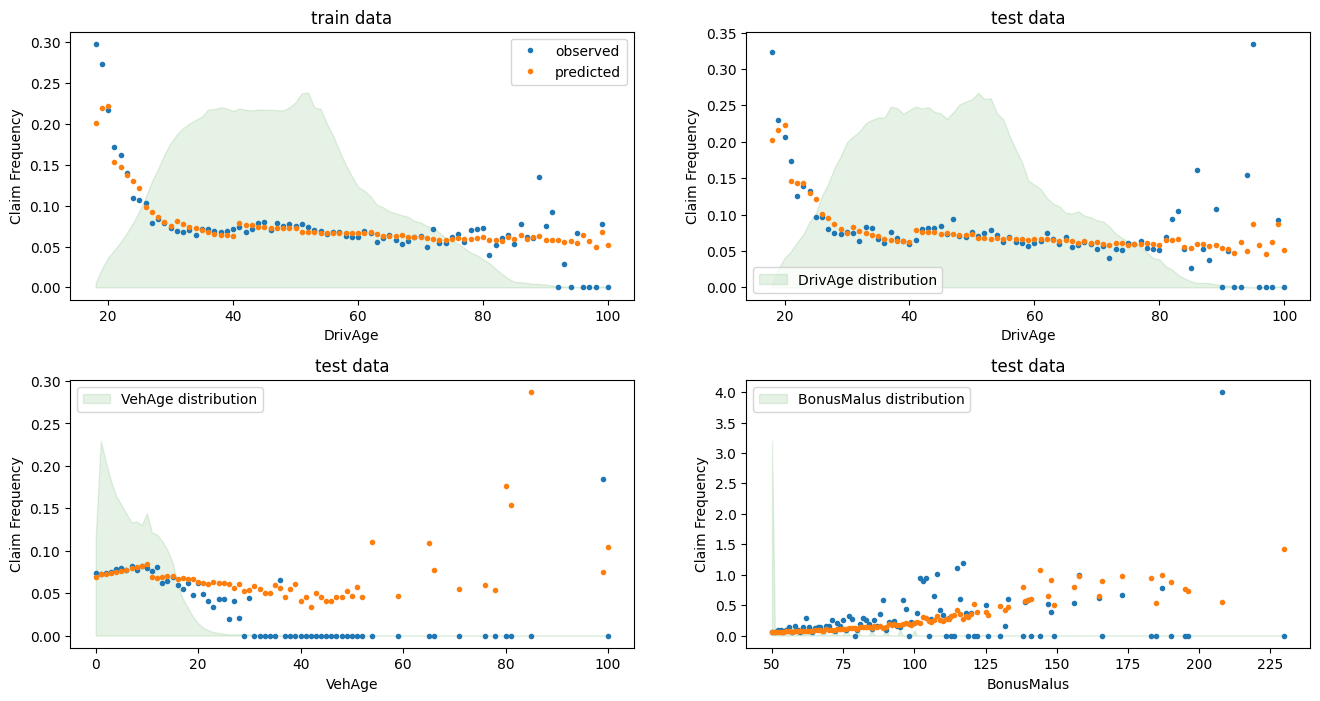

In [4]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=poisson_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0, 0],
)

plot_obs_pred(
    df=df_test,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=poisson_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 1],
    fill_legend=True,
)

plot_obs_pred(
    df=df_test,
    feature="VehAge",
    weight="Exposure",
    observed="Frequency",
    predicted=poisson_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 0],
    fill_legend=True,
)

plot_obs_pred(
    df=df_test,
    feature="BonusMalus",
    weight="Exposure",
    observed="Frequency",
    predicted=poisson_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 1],
    fill_legend=True,
)

# According to the observed data, the frequency of accidents is higher for drivers younger than 30 years old, 
# and is positively correlated with the BonusMalus variable. 
# Our model is able to mostly correctly model this behaviour.

In [5]:
## Fit Gamma model to Severity (AvgClaimAmount)
# We fit a GLM model for the severity with the same features as the frequency model.
# We filter out ClaimAmount == 0 as the Gamma distribution has support on (0,inf), not [0, inf].
# We use ClaimNb as sample_weight to account for policies that contain more than one claim.

from sklearn.linear_model import GammaRegressor

mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

gamma_sev = GammaRegressor(alpha=10, max_iter=400)
gamma_sev.fit(X_train[mask_train.values],
              df_train.loc[mask_train, "AvgClaimAmount"],
              sample_weight=df_train.loc[mask_train, "ClaimNb"])

scores = score_estimator(
    gamma_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
display(scores)

Evaluation of GammaRegressor on target AvgClaimAmount


subset,train,test
metric,,
D² explained,1.700000e-03,1.600000e-03
mean abs. error,1.562512e+03,1.575774e+03
mean squared error,2.843110e+07,2.855044e+07


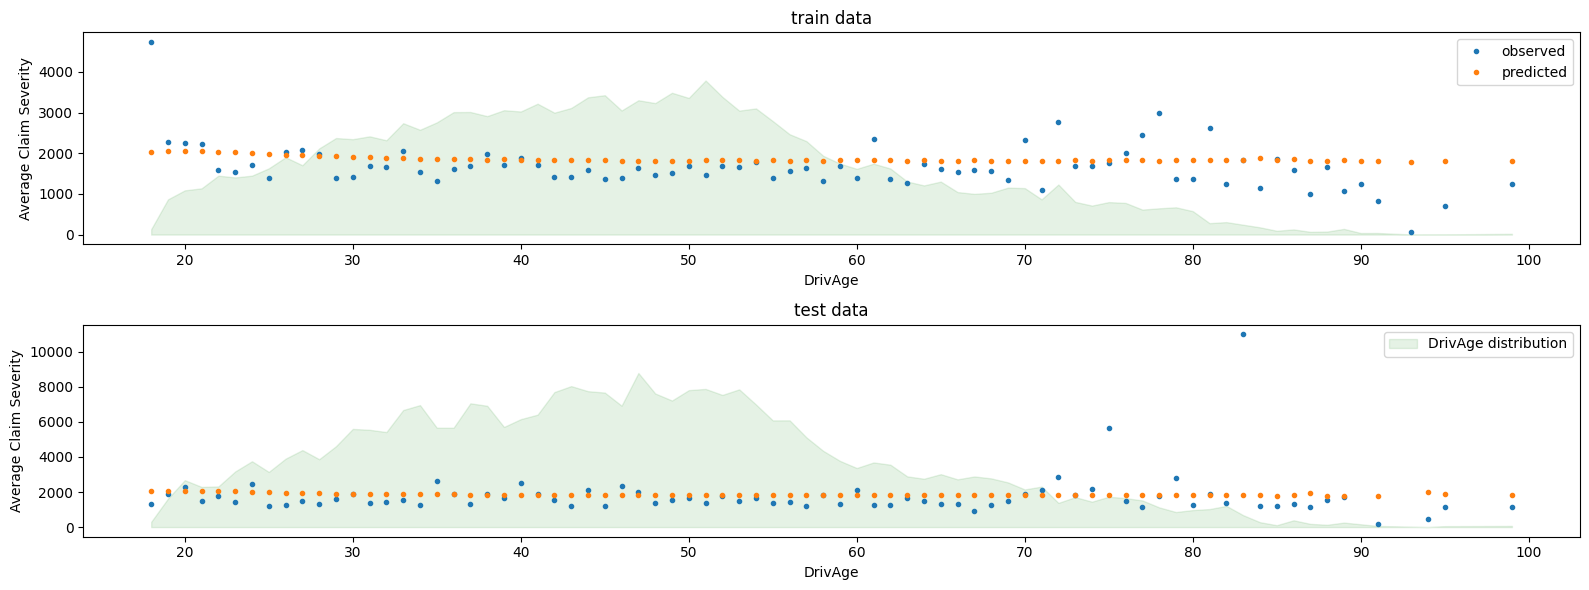

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(
    df=df_train.loc[mask_train],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=gamma_sev.predict(X_train[mask_train.values]),
    y_label="Average Claim Severity",
    title="train data",
    ax=ax[0],
)

plot_obs_pred(
    df=df_test.loc[mask_test],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=gamma_sev.predict(X_test[mask_test.values]),
    y_label="Average Claim Severity",
    title="test data",
    ax=ax[1],
    fill_legend=True,
)
plt.tight_layout()

In [7]:
# Use both product of frequency model and severity model to predict pure premium

scores_poisson_gamma = score_estimator(
    (poisson_freq, gamma_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=None,
)

print("Evaluation of Poisson-Gamma model on target PurePremium")
display(scores_poisson_gamma)

Evaluation of Poisson-Gamma model on target PurePremium


subset,train,test
metric,,
mean abs. error,2.572478e+02,2.581327e+02
mean squared error,1.567328e+07,1.484943e+07


In [8]:
# Fit a tweedie model to predict pure premium with some regularization

from sklearn.linear_model import TweedieRegressor


tweedie = TweedieRegressor(power=1.999, alpha=0.1, max_iter=10000)
tweedie.fit(
    X_train, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

tweedie_powers = [1.25, 1.5, 1.7, 1.8, 1.9, 1.999]


scores_tweedie = score_estimator(
    tweedie,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

print("Evaluation of Tweedie model on target PurePremium")
display(scores_tweedie)

Evaluation of Tweedie model on target PurePremium


subset,train,test
metric,,
D² explained,2.000000e-04,2.000000e-04
mean Tweedie dev p=1.2500,2.529866e+02,2.544736e+02
mean Tweedie dev p=1.5000,7.400870e+01,7.446850e+01
mean Tweedie dev p=1.7000,3.620800e+01,3.639130e+01
mean Tweedie dev p=1.8000,3.004960e+01,3.016540e+01
mean Tweedie dev p=1.9000,3.364650e+01,3.371880e+01
mean Tweedie dev p=1.9990,1.914443e+03,1.914297e+03
mean abs. error,2.579749e+02,2.587567e+02
mean squared error,1.567560e+07,1.485082e+07


In [10]:
# Fit a Random Forest (RF) regressor to predict pure premium

from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=30, max_depth=5, min_samples_split=5,random_state=42)
random_forest.fit(X_train, df_train["PurePremium"].values)

scores_rf = score_estimator(
    random_forest,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=None,
)

print("Evaluation of RF model on target PurePremium")
display(scores_rf)

Evaluation of RF model on target PurePremium


subset,train,test
metric,,
D² explained,-1.120000e-01,-1.715000e-01
mean abs. error,4.065244e+02,4.102805e+02
mean squared error,1.743855e+07,1.740713e+07


In [11]:
# Fit a Gradient Boosting Regressor to predict pure premium

from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=30, max_depth=3, min_samples_split=4, random_state=42)
gradient_boosting.fit(X_train, df_train["PurePremium"].values)

scores_gb = score_estimator(
    gradient_boosting,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=None,
)

print("Evaluation of GB model on target PurePremium")
display(scores_gb)

Evaluation of GB model on target PurePremium


subset,train,test
metric,,
D² explained,-1.684000e-01,-2.746000e-01
mean abs. error,4.079440e+02,4.104779e+02
mean squared error,1.832283e+07,1.894011e+07


In [19]:
res = []
for model, scores in zip(
                            ['PG', 'TW', 'RF', 'GB'],
                            [scores_poisson_gamma, scores_tweedie, scores_rf, scores_gb]
                            ):
    res.append(
        [model, scores[scores.index=="mean abs. error"]['test'].values[0], scores[scores.index=="mean squared error"]['test'].values[0]]
    )

res = pd.DataFrame(res, columns=['model', 'test MAE', 'test MSE'])
display(res)


,model,test MAE,test MSE
0,PG,258.1327,1.484943e+07
1,TW,258.7567,1.485082e+07
2,RF,410.2805,1.740713e+07
3,GB,410.4779,1.894011e+07
